In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
from scipy import linalg
from scipy import signal
from scipy.signal import butter, filtfilt

In [3]:
def print_structure(name, obj):
    obj_type = "Group" if isinstance(obj, h5py.Group) else "Dataset"
    info = f" | shape: {obj.shape} | dtype: {obj.dtype}" if isinstance(obj, h5py.Dataset) else ""
    print(f"{obj_type}: {name}{info}")

with h5py.File('SaSR_test.hdf5', 'r') as f:
    f.visititems(print_structure)


Group: SR
Dataset: SR/V1:ENV_CEB_SEIS_V | shape: (1800000,) | dtype: float32
Dataset: SR/V1:ENV_CEB_SEIS_V_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F0_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F0_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F1_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F1_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F2_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F2_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F3_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F3_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F4_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F4_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F7_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F7_LVDT_V

In [4]:
with h5py.File('SaSR_test.hdf5', 'r') as f:
    dset = f['SR/V1:ENV_CEB_SEIS_V_dec']
    for key, value in dset.attrs.items():
        print(f"{key}: {value}")

channel: V1:ENV_CEB_SEIS_V_dec
sample_rate: 62.5
t0: 1431561618.0
units: m.s-1


In [5]:
f = h5py.File('SaSR_test.hdf5', 'r')
data = f['SR/V1:ENV_CEB_SEIS_V_dec'][:]  # The [:] loads the actual data into memory

def data_info(data):
    print('Data loaded from HDF5 file: V1:ENV_CEB_SEIS_V_dec')
    print(f'Shape: {data.shape}') 
    print(f'Dtype: {data.dtype}')
    print(f'Length: {len(data)}')
    print(f'First 5 values: {data[:5]}')
    print(f'Last 5 values: {data[-5:]}')
    print(f'Min value: {data.min()}')
    print(f'Max value: {data.max()}')

data_info(data)

Data loaded from HDF5 file: V1:ENV_CEB_SEIS_V_dec
Shape: (112500,)
Dtype: float32
Length: 112500
First 5 values: [ -17.462273   -8.134678   59.074474  502.19055  1561.6556  ]
Last 5 values: [203.64767 268.39673 285.65677 240.61739 167.3082 ]
Min value: -3092.741455078125
Max value: 7177.04931640625


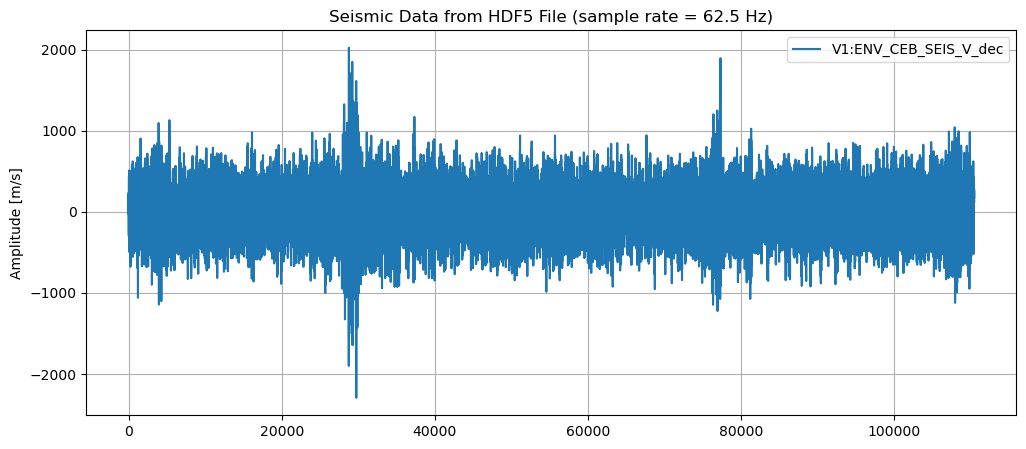

In [41]:
# Plotting the data
#time domain
plt.figure(figsize=(12, 5))
plt.plot(data[2000:], label='V1:ENV_CEB_SEIS_V_dec')
plt.title('Seismic Data from HDF5 File (sample rate = 62.5 Hz)')
plt.ylabel('Amplitude [m/s]')
plt.legend()
plt.grid()
plt.show()


In [42]:
new_data = data[2000:]

Text(0, 0.5, 'Amplitude [m/√Hz]')

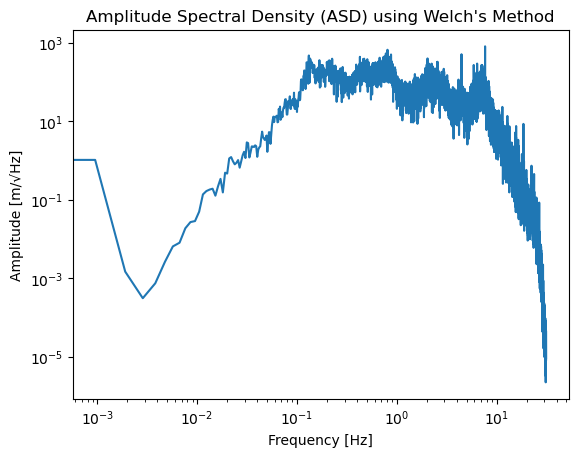

In [61]:
#compute the power spectral density (PSD) using Welch's method
nperseg = 2**16 #number of samples per segment
#Welch method computes an estimate of the power spectral density by dividing the data into overlapping segments
#fs = sampling frequency (Hz) = 62.5
f, Pxx = signal.welch(new_data, fs=62.5, window='hann', nperseg=nperseg)
#returns the array of sample frequencies (f) and the corresponding power spectral density values (Pxx)
#compute the differential frequency spacing df
df = np.diff(f)
varxx = np.cumsum(np.flip(df * Pxx[0:-1])) #cumulative sum of the PSD
plt.loglog(f, np.sqrt(Pxx)) #plot the sqrt of the PSD (i.e. the amplitude spectrum)
plt.title('Amplitude Spectral Density (ASD) using Welch\'s Method')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [m/√Hz]')


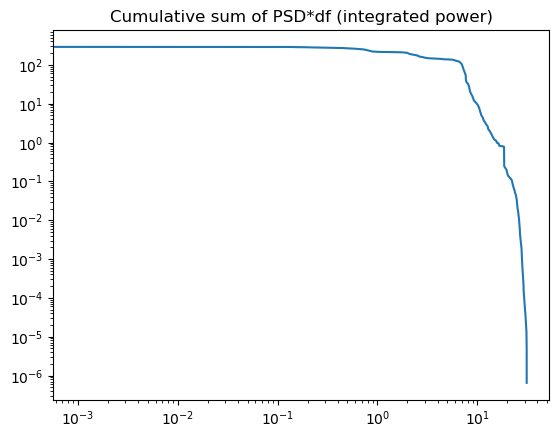

In [13]:
plt.title('Cumulative sum of PSD*df (integrated power)')
plt.loglog(f[0:-1], np.flip(np.sqrt(varxx)))


In [46]:
new_data.size

110500

In [48]:
#take the fourier transform of the data
#log scale the data

ftransform = np.fft.fft(new_data)
print(ftransform[:10])

[1902.87544082  +0.j          960.92911809 +46.22767327j
  963.4360035  +72.07459129j  957.11192103 +99.68372107j
  956.74528143+131.88604111j  956.73730218+163.18945595j
  955.75001253+195.07429383j  953.9649508 +227.49929161j
  952.73977174+259.83404611j  957.32119486+289.53873571j]


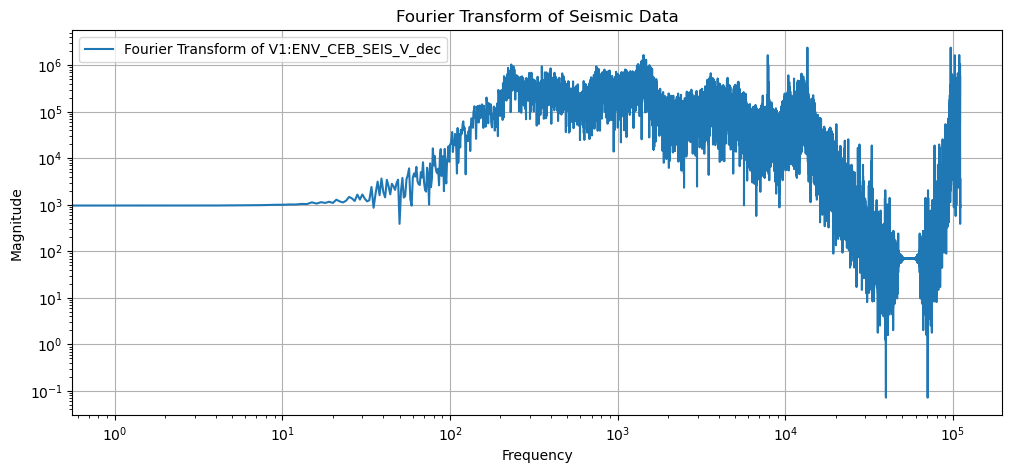

In [63]:
#plot the fourier transform
plt.figure(figsize=(12, 5))
plt.loglog((np.abs(ftransform)), label='Fourier Transform of V1:ENV_CEB_SEIS_V_dec') 
plt.title('Fourier Transform of Seismic Data')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.grid()

In [ ]:
frequencies = np.fft.fftfreq(new_data.size, d = 1/62.5)
#multiply the FT by 2 pi f 
ft_freq = ftransform * frequencies * 2 * np.pi


[-0.12327323 +1552.01425926j  0.12327323+13642.11443942j
 -0.12327323 +8234.0838103j   0.12327323 +5195.0785665j
 -0.12327323 -4195.67023945j  0.12327323 -7954.25663331j
 -0.12327323-10859.64448766j  0.12327323 -6691.68254211j
 -0.12327323 -1643.36573823j  0.12327323 +6172.59024604j]


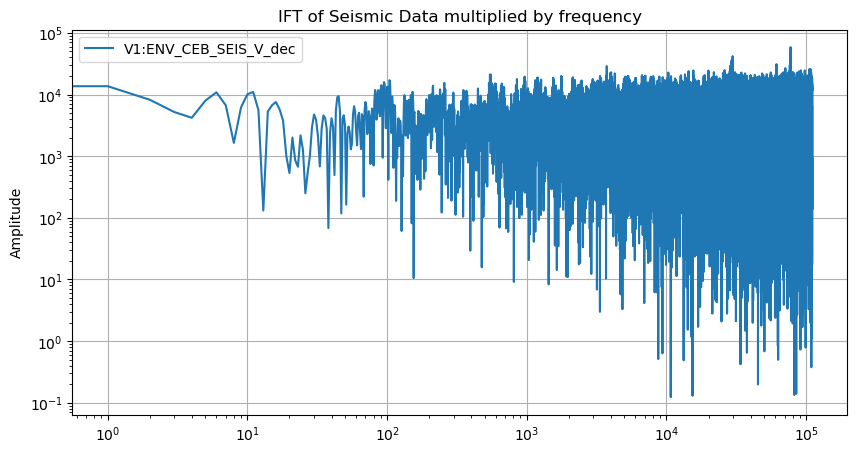

In [59]:
#take the inverse fourier transform
ift = np.fft.ifft(ft_freq)
print(ift[:10])
#plot the inverse fourier transform
plt.figure(figsize=(10, 5))
plt.loglog((np.abs(ift)), label='V1:ENV_CEB_SEIS_V_dec')
plt.title('IFT of Seismic Data multiplied by frequency')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()



In [21]:
ft_fixed_freq = 0.16 * ftransform * 2 * np.pi

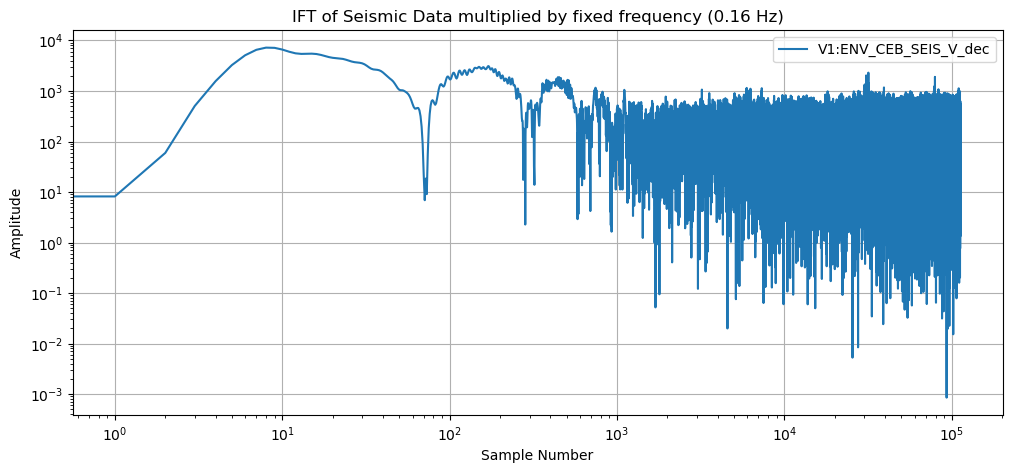

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(np.abs(np.fft.ifft(ft_fixed_freq)), label='V1:ENV_CEB_SEIS_V_dec')
plt.yscale('log')
plt.xscale('log')
plt.title('IFT of Seismic Data multiplied by fixed frequency (0.16 Hz)')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

In [23]:
with h5py.File('SaSR_test.hdf5', 'r') as f:
    dset = f['SR/V1:ENV_CEB_SEIS_V']
    for key, value in dset.attrs.items():
        print(f"{key}: {value}")

channel: V1:ENV_CEB_SEIS_V
sample_rate: 500.0
t0: 1431561618.0
units: m.s-1


In [24]:
with h5py.File('SaSR_test.hdf5', 'r') as f:
    # Load the seismic data
    seism = f['SR/V1:ENV_CEB_SEIS_V'][:]

In [25]:
ftransform500 = np.fft.fft(seism)
frequencies500 = np.fft.fftfreq(seism.size, d = 1/500)
#multiply the FT by 2 pi f
ft_freq500 = ftransform500 * frequencies500 * 2 * np.pi
#take the inverse fourier transform
ift500 = np.fft.ifft(ft_freq500)


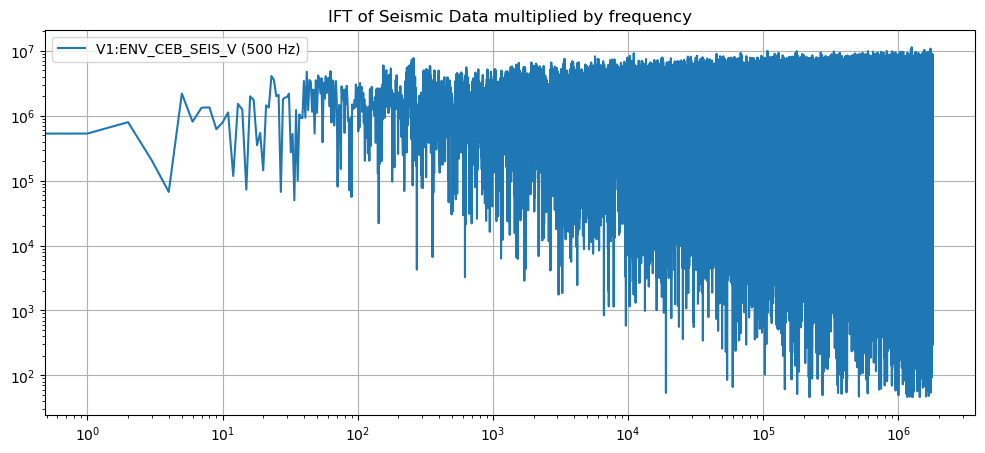

In [26]:
plt.figure(figsize=(12, 5))
plt.loglog(np.abs(ift500), label='V1:ENV_CEB_SEIS_V (500 Hz)')
plt.title('IFT of Seismic Data multiplied by frequency')
plt.legend()
plt.grid()
plt.show()

In [27]:
#apply a filter
high = 0.2 #cut-off frequency
order = 4 #order of the filter
b, a = signal.butter(order, Wn=high, btype='lowpass', output='ba', fs=500) #fs = sampling frequency
    #filtfilt is a zero-phase filter, so it doesn't introduce any phase distortion

data_filtered = signal.filtfilt(b, a, seism) 

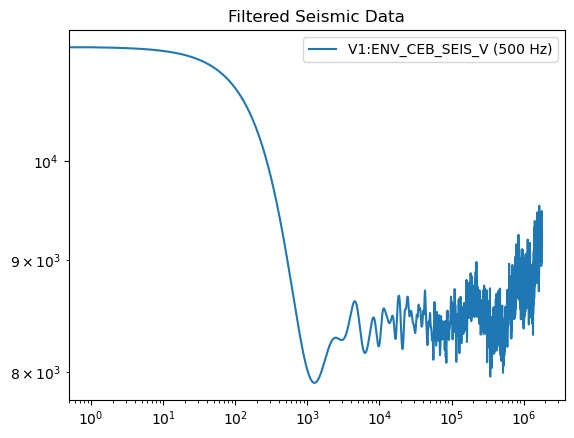

In [28]:
plt.loglog(data_filtered, label='V1:ENV_CEB_SEIS_V (500 Hz)')
plt.title('Filtered Seismic Data')
plt.legend()
plt.show()

In [29]:
ft_filtered = np.fft.fft(data_filtered)
frequencies_filtered = np.fft.fftfreq(data_filtered.size, d = 1/500)
#multiply the FT by 2 pi f
ft_freq_filtered = ft_filtered * frequencies_filtered * 2 * np.pi
#take the inverse fourier transform
ift_filtered = np.fft.ifft(ft_freq_filtered)


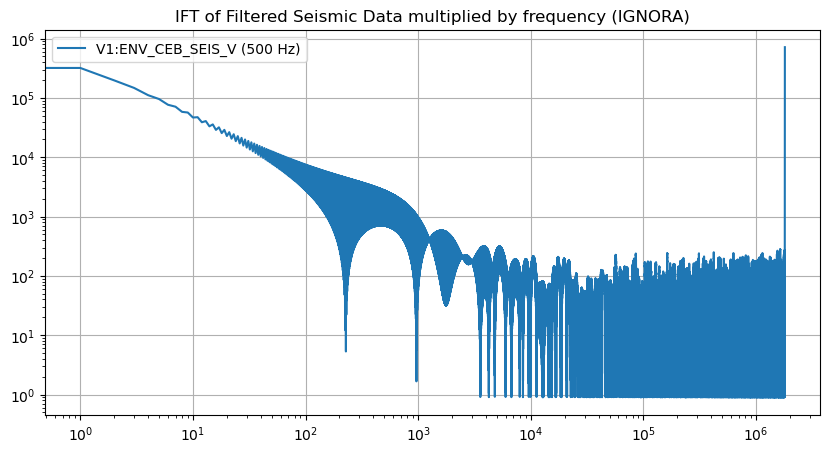

In [30]:
plt.figure(figsize=(10, 5))
plt.loglog(np.abs(ift_filtered), label='V1:ENV_CEB_SEIS_V (500 Hz)')
plt.title('IFT of Filtered Seismic Data multiplied by frequency (IGNORA)')
plt.legend()
plt.grid()
plt.show()

In [31]:
with h5py.File('SaSR_test.hdf5', 'r') as f:
    # Load the seismic data
    f0_data = f['SR/V1:Sa_SR_F0_LVDT_V_500Hz_dec'][:]

In [32]:
with h5py.File('SaSR_test.hdf5', 'r') as f:
    dset = f['SR/V1:Sa_SR_F0_LVDT_V_500Hz_dec']
    for key, value in dset.attrs.items():
        print(f"{key}: {value}")

channel: V1:Sa_SR_F0_LVDT_V_500Hz_dec
sample_rate: 62.5
t0: 1431561618.0
units: um


In [33]:
high = 0.2 #cut-off frequency
order = 4 #order of the filter
b, a = signal.butter(order, Wn=high, btype='lowpass', output='ba', fs=62.5) #fs = sampling frequency
    #filtfilt is a zero-phase filter, so it doesn't introduce any phase distortion
    #it filters the signal starting from index 2000 (perché??)
data_filtered_f0 = signal.filtfilt(b, a, f0_data[2000:])

In [34]:
fr, psd = signal.welch(data_filtered_f0, fs=62.5, window='hann', nperseg=2**16)

Text(0.5, 0, 'Frequency [Hz]')

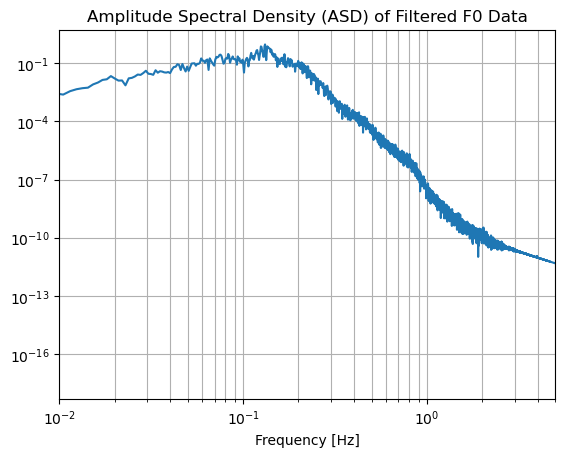

In [36]:
plt.loglog(fr, np.sqrt(psd))
plt.xlim(1.e-2, 5.e0)
plt.ylim([5e-19, 5.222394985518984])
plt.grid(which='both', axis='both')
plt.title('Amplitude Spectral Density (ASD) of Filtered F0 Data')
plt.xlabel('Frequency [Hz]')


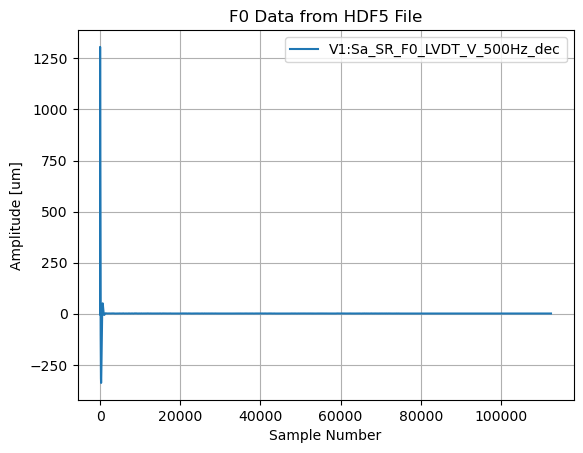

In [37]:
plt.plot(f0_data, label='V1:Sa_SR_F0_LVDT_V_500Hz_dec')
plt.title('F0 Data from HDF5 File')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude [um]')
plt.legend()
plt.grid()
plt.show()

In [38]:
f0_fft = np.fft.fft(f0_data)
frequencies_f0 = np.fft.fftfreq(f0_data.size, d = 1/62.5)
#multiply the FT by 2 pi f
ft_freq_f0 = f0_fft * frequencies_f0 * 2 * np.pi
#take the inverse fourier transform
ift_f0 = np.fft.ifft(ft_freq_f0)


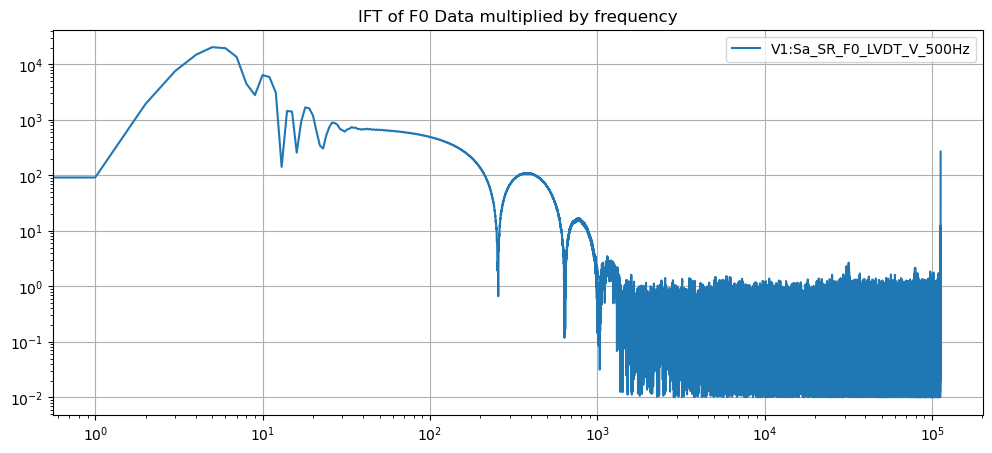

In [39]:
plt.figure(figsize=(12, 5))
plt.loglog(np.abs(ift_f0), label='V1:Sa_SR_F0_LVDT_V_500Hz')
plt.title('IFT of F0 Data multiplied by frequency')
plt.legend()
plt.grid()
plt.show()